# Get Data

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "./parsed_chat_data.csv"

if not os.path.exists(data_dir):
  # !wget https://raw.githubusercontent.com/stran123/6.864-final-project/main/data/mini_parsed_data.csv -O ./mini_data.csv
  !wget https://raw.githubusercontent.com/stran123/6.864-final-project/main/data/parsed_chat_data.zip -O ./parsed_chat_data.zip
  !unzip parsed_chat_data.zip -d .

Mounted at /content/gdrive
--2021-05-18 18:23:21--  https://raw.githubusercontent.com/stran123/6.864-final-project/main/data/parsed_chat_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10794217 (10M) [application/zip]
Saving to: ‘./parsed_chat_data.zip’

./parsed_chat_data. 100%[===================>]  10.29M  44.3MB/s    in 0.2s    

2021-05-18 18:23:22 (44.3 MB/s) - ‘./parsed_chat_data.zip’ saved [10794217/10794217]

Archive:  parsed_chat_data.zip
  inflating: ./parsed_chat_data.csv  
  inflating: ./__MACOSX/._parsed_chat_data.csv  


# Preprocessing (parse messages)

In [ ]:
# import spacy
# tokenizer = spacy.load('en_core_web_sm')

# tokenized_msgs = []

# df['parsed_msg'] = None
# for i, msg in tqdm(enumerate(df['message'].values[:100])):
#   tokenized_msg = tokenizer(msg[1:])
#   df['parsed_msg'][i]=' '.join([token.text for token in tokenized_msg])

# df.to_csv('mini_parsed_data.csv')

# Read Data

In [7]:
import pandas as pd
import spacy
import pickle
from tqdm.notebook import tqdm

df = pd.read_csv(data_dir)
df = df[['conversation_id','message','parsed_msg']][:]

df[['message']]

,message
0,Are you a fan of Google or Microsoft?
1,Both are excellent technology they are helpfu...
2,"I'm not a huge fan of Google, but I use it a..."
3,Google provides online related services and p...
4,"Yeah, their services are good. I'm just not a..."
...,...
188373,"Wow, it does not seem like that long. Since I..."
188374,"I havent seen that episode, I might google it..."
188375,I don't think I have either. That's an insane...
188376,"I did, my little brother used to love Thomas ..."


In [3]:
df

,conversation_id,message,parsed_msg
0,1,Are you a fan of Google or Microsoft?,Are you a fan of Google or Microsoft ?
1,1,Both are excellent technology they are helpfu...,Both are excellent technology they are helpful...
2,1,"I'm not a huge fan of Google, but I use it a...","I 'm not a huge fan of Google , but I use it..."
3,1,Google provides online related services and p...,Google provides online related services and pr...
4,1,"Yeah, their services are good. I'm just not a...","Yeah , their services are good . I 'm just not..."
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...","Wow , it does not seem like that long . Since ..."
188374,8628,"I havent seen that episode, I might google it...","I have nt seen that episode , I might google i..."
188375,8628,I don't think I have either. That's an insane...,I do n't think I have either . That 's an insa...
188376,8628,"I did, my little brother used to love Thomas ...","I did , my little brother used to love Thomas ..."


# Add START and PAD tokens. Split data into train/val

In [8]:
START=['[start]']
PAD=['[pad]']
END = ['[end]']

longest_msg = START + max(df['parsed_msg'], key=lambda x: len(str(x).strip().split(' '))).split(' ') + END
num_convos = max(df['conversation_id'], key=lambda x: int(x))

train_data = []
valid_data = []
vocab = {START[0], PAD[0], END[0]}
prev_conv_id = 0
training_over = False
training_split = 0.8

for conv_id, _, parsed_msg in df.values:
  if conv_id > num_convos*0.8:
    training_over = True

  if prev_conv_id != conv_id:
    if not training_over:
      train_data.append(START+END+PAD*(len(longest_msg)-2))
    else:
      valid_data.append(START+END+PAD*(len(longest_msg)-2))
    prev_conv_id = conv_id

  parsed_msg_split = str(parsed_msg).strip().lower().split(' ')
  vocab |= set(parsed_msg_split)

  if not training_over:
    train_data.append(START + parsed_msg_split + END +PAD*(len(longest_msg)-len(parsed_msg_split)-2))
  else:
    valid_data.append(START + parsed_msg_split + END +PAD*(len(longest_msg)-len(parsed_msg_split)-2))

In [9]:
vocab = list(vocab)
vocab_oh = {w:i for i,w in enumerate(vocab)}
train_data_encoded = []
valid_data_encoded = []
PAD_INDEX = vocab_oh["[pad]"]
for msg in train_data:
  msg_vectorized = []
  for word in msg:
    msg_vectorized.append(vocab_oh[word.lower()])
  train_data_encoded.append(msg_vectorized)

for msg in valid_data:
  msg_vectorized = []
  for word in msg:
    msg_vectorized.append(vocab_oh[word.lower()])
  valid_data_encoded.append(msg_vectorized)


In [10]:
print(train_data[1])
print(train_data[2])

['[start]', 'are', 'you', 'a', 'fan', 'of', 'google', 'or', 'microsoft', '?', '[end]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pa

In [ ]:
def get_len(sent):
  for i, elt in enumerate(sent):
    if elt == vocab_oh["[pad]"]:
      return i
  return i + 1

In [ ]:
from torch.utils import data
class ChatBotDataset(data.Dataset):
  def __init__(self, train_data):
    self.data = train_data

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index):
    self.src, self.src_len, self.tgt, self.tgt_len = self.data[index]
    return self.src, self.src_len, self.tgt, self.tgt_len

In [ ]:
import random
import torch
from tqdm.notebook import tqdm
random.seed(0)

batch_size = 4

training_data_x = torch.tensor(train_data_encoded)
validation_data_x = torch.tensor(valid_data_encoded)
training_data_y = torch.cat((training_data_x[1:,:], training_data_x[0:1,:]), axis=0)
validation_data_y = torch.cat((validation_data_x[1:,:], validation_data_x[0:1,:]), axis=0)

training_data = list(zip(training_data_x, training_data_y))
validation_data = list(zip(validation_data_x, validation_data_y))

all_data = training_data + validation_data
random.shuffle(all_data)

training_data = all_data[:int(len(all_data)*training_split)]
validation_data = all_data[int(len(all_data)*training_split):]

training_data  = training_data[:1000]
validation_data = validation_data[:100]


train_src, train_tgt = zip(*training_data)
train_src, train_tgt = torch.cat(train_src,dim=0).reshape(-1,len(longest_msg)), torch.cat(train_tgt,dim=0).reshape(-1,len(longest_msg))
train_dataset = ChatBotDataset(list(zip(train_src, map(get_len, train_src), train_tgt, map(get_len,train_tgt))))
train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

val_src, val_tgt = zip(*validation_data)
val_src, val_tgt = torch.cat(val_src,dim=0).reshape(-1,len(longest_msg)), torch.cat(val_tgt,dim=0).reshape(-1,len(longest_msg))

val_dataset = ChatBotDataset(list(zip(val_src, map(get_len, val_src), val_tgt, map(get_len,val_tgt))))
val_data_loader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# DistilBERT

In [ ]:
!pip install transformers
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    
    super(Encoder, self).__init__()

    # --------- Your code here --------- #
    # feel free to use a pre-implemented pytorch GRU
    # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
    # self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True, bidirectional=True, dropout=dropout) 
    self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states=True)
    self.hidden_size = hidden_size
    # --------- Your code ends --------- #

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).

      Hint: `outputs` and `finals` are both standard GRU outputs.
    """
    '''
    outputs = None
    finals = None
    # --------- Your code here --------- #
    # hint: you probably want to pack the inputs and outputs (see note below)
    #       https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
    # hint2: given the shape of the inputs and outputs, 
    #        it might be helpful to specify batch_first=True (also in __init___)
    # hint3: MAX_SENT_LENGTH_PLUS_SOS_EOS is a global variable that exists if 
    #        you ever need to specify a total_length for outputs
    
    packed = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True, enforce_sorted=False)
    outputs, finals = self.rnn(packed)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True)

    # we need to manually concatenate the final states for both directions
    fwd_final = finals[0:finals.size(0):2]
    bwd_final = finals[1:finals.size(0):2]
    finals = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]
    '''
    inputs = self.tokenizer([' '.join([vocab[idx] for idx in row]) for row in inputs], return_tensors="pt", padding=True).to(device)
    outputs = self.distilbert(**inputs)
    finals = torch.mean(outputs.last_hidden_state.unsqueeze(0), axis=2)
    # --------- Your code ends --------- #
    return outputs.hidden_states, finals

In [ ]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    # --------- Your code here --------- #
    # hint: you need more layers than the encoder
    #       again, feel free to use pytorch implemetnations
    
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True,
                      dropout=dropout)

    # To initialize from the final encoder state.
    self.bridge = nn.Linear(768, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + input_size, hidden_size,
                                      bias=False)
    
    # --------- Your code ends --------- #

  def forward_step(self, prev_embed, hidden):
    """Helper function for forward below:
       Perform a single decoder step (1 word).

       Inputs:
      - `prev_embed`: a 3d-tensor of shape (batch_size, 1, embed_size)
          representing the padded embedded word vectors at this step in training
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the current hidden state.

      Returns:
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the current decoder hidden state.
      - `pre_output`: a 3d-tensor of shape (batch_size, 1, hidden_size)
          representing the total decoder output for one step
    """
    pre_output = None
    # --------- Your code here --------- #
    pre_output, hidden = self.rnn(prev_embed, hidden) # minimun necessary

    # this is "extra"
    pre_output = torch.cat([prev_embed, pre_output], dim=2)

    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)
    # --------- Your code ends --------- #
    return hidden, pre_output

  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs = None
    
    # --------- Your code here --------- #

    # Unroll the decoder RNN for `max_len` steps.
    # hint: use the above helper function forward_step that 
    #       performs a single decoder step (1 word).

    # Here we store all intermediate hidden states and pre-output vectors.
    pre_output_vectors = []

    # Unroll the decoder RNN for `max_len` steps.
    for i in range(max_len):
      prev_embed = inputs[:, i].unsqueeze(1)
      hidden, pre_output = self.forward_step(prev_embed, hidden)
      pre_output_vectors.append(pre_output)

    outputs = torch.cat(pre_output_vectors, dim=1)
  
    # --------- Your code ends --------- #
    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))
    
    return decoder_init_hiddens

In [ ]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: a `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens   # unused
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(src_ids, src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

In [ ]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(tqdm(data_loader)):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)

    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in tqdm(range(num_epochs)):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)
        
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

# Hyperparameters

In [ ]:

# learning_rate = 1e-3
# dropout = 0.5
# epochs = 30
# loss_fn = nn.NLLLoss(reduction="sum", ignore_index=vocab_oh['[pad]'])
# hidden_size = 1024
# embedder_layers = 2

# Training

## Training Model

In [ ]:
#model = Predictor(len(vocab), embedder_layers, hidden_size, dropout)
#train_losses = []
#test_losses = []
#print_every = 30
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

MODEL_FOLDER = "/content/drive/MyDrive/mit-6864/final-project"
MODEL_NAME = "original_model"
!mkdir -p "/content/drive/MyDrive/mit-6864/final-project"

In [ ]:
# Hyperparameters for contructing the encoder-decoder model.
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

model = EncoderDecoder(
    encoder=Encoder(embed_size, hidden_size, dropout=dropout),
    decoder=Decoder(embed_size, hidden_size, dropout=dropout),
    src_embed=nn.Embedding(len(vocab), embed_size),
    trg_embed=nn.Embedding(len(vocab), embed_size),
    generator=Generator(hidden_size, len(vocab))).to(device)

train_model = True
if train_model:
  # Start training. The returned `dev_ppls` is a list of dev perplexity for each
  # epoch.
  model_ppls = train(model, num_epochs=10, learning_rate=1e-3,
                        print_every=100)
  
  torch.save(model.state_dict(), MODEL_FOLDER+"/" + "modelDistilbert.pt")
  with open("vocab_list_distilbert.pkl", "wb") as f:
    pickle.dump(vocab,f)


else:
  model.load_state_dict(torch.load(MODEL_FOLDER+"/" + "model.pt"))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout,

Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch Step: 0 Loss: 246.160004
Epoch Step: 100 Loss: 37.909267
Epoch Step: 200 Loss: 167.661743




Validation perplexity: 378.886478
Epoch 1


Epoch Step: 0 Loss: 101.156715
Epoch Step: 100 Loss: 132.700043
Epoch Step: 200 Loss: 105.286629




Validation perplexity: 357.135688
Epoch 2


Epoch Step: 0 Loss: 105.968498
Epoch Step: 100 Loss: 117.852791
Epoch Step: 200 Loss: 95.540085




Validation perplexity: 377.693661
Epoch 3


Epoch Step: 0 Loss: 88.140846
Epoch Step: 100 Loss: 138.865448
Epoch Step: 200 Loss: 106.186668




Validation perplexity: 466.534438
Epoch 4


Epoch Step: 0 Loss: 60.969738
Epoch Step: 100 Loss: 67.860153
Epoch Step: 200 Loss: 118.952011




Validation perplexity: 687.453637
Epoch 5


Epoch Step: 0 Loss: 44.918945
Epoch Step: 100 Loss: 67.902733
Epoch Step: 200 Loss: 79.478439




Validation perplexity: 801.945409
Epoch 6


Epoch Step: 0 Loss: 69.214355
Epoch Step: 100 Loss: 54.763474
Epoch Step: 200 Loss: 46.248539




Validation perplexity: 1152.402448
Epoch 7


Epoch Step: 0 Loss: 32.466965
Epoch Step: 100 Loss: 42.340546
Epoch Step: 200 Loss: 48.567863




Validation perplexity: 1712.004576
Epoch 8


Epoch Step: 0 Loss: 39.696480
Epoch Step: 100 Loss: 47.436672
Epoch Step: 200 Loss: 41.811947




Validation perplexity: 2558.241466
Epoch 9


Epoch Step: 0 Loss: 35.206646
Epoch Step: 100 Loss: 33.278687
Epoch Step: 200 Loss: 43.385689




Validation perplexity: 3598.187959



In [ ]:
# state_dict = torch.load("lstm_model_epoch_final.pt")
# print(state_dict.keys())
# model.load_state_dict(state_dict)

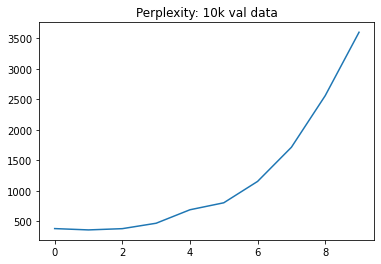

In [ ]:
import matplotlib.pyplot as plt
window_size = 10
plt.title("Perplexity: 10k val data")
plt.plot(model_ppls)

In [ ]:
# from google.colab import files
# files.download("lstm_model_epoch_final")

In [ ]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder. Make sure to chop off the 
     EOS token!"""
  SOS_INDEX = vocab_oh["[start]"]
  EOS_INDEX = vocab_oh["[end]"]
  model.eval()
  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None
  print(encoder_finals[:,:,:10])
  # --------- Your code here --------- #
  for i in range(max_len):
    with torch.no_grad():
      hidden, pre_output = model.decode(encoder_finals, prev_y, hidden)
      
      prob = model.generator(pre_output[:,-1])
    _, next_word = torch.max(prob,dim=1)
    next_word = next_word.data.item()
    
    output.append(next_word)
    prev_y = torch.ones(1, 1).fill_(next_word).type_as(src_ids)

  output = np.array(output)
  
  if EOS_INDEX is not None:
      first_eos = np.where(output==EOS_INDEX)[0]
      if len(first_eos) > 0:
          output = output[:first_eos[0]]   
  # --------- Your code ends --------- #
  
  return output

In [ ]:
import spacy
import torch
import numpy as np
from collections import Counter

tokenizer = spacy.load('en_core_web_sm')

LONGEST_MSG_LENGTH = len(longest_msg)

def get_padded_len(msg):
  msg_copy = msg.copy()
  msg_copy = [elt for elt in msg_copy if elt != '[pad]']
  return len(msg_copy)

for elt in train_data[:10]:
  j = elt.index('[end]')
  x = " ".join(elt[1:j])
  # x = input("Say something to the bot:\n")
  x = x.lower()
  PAD = ['[pad]']
  tokenized_msg = tokenizer(x)
  
  
  
  parsed_msg = ' '.join([token.text for token in tokenized_msg])
  split_msg = parsed_msg.split(' ')
  
  msg_len = get_padded_len(split_msg)
  if len(split_msg) < LONGEST_MSG_LENGTH:
    padded_msg = START + split_msg + END + PAD*(LONGEST_MSG_LENGTH-len(split_msg)-2)
  else:
    raise ValueError("Message is too long!")
  
  one_hotted_msg = torch.tensor(list(map(lambda word: vocab_oh[word], padded_msg))).unsqueeze(0)
  y = greedy_decode(model, one_hotted_msg.to(device), torch.tensor(msg_len).unsqueeze(0).to(device),
                          max_len=len(longest_msg))
  output_msg = ' '.join([vocab[i] for i in y])
  print(output_msg)
  print("_______")

tensor([[[ 0.0990, -0.0069,  0.1840, -0.0413, -0.8334, -0.7664,  0.3476,
          -0.1949, -0.9624, -0.3078]]], device='cuda:0')
i do .   i do however know that allen iverson is going to go to be such as such as such as such as such as such as such as such as such as such as such as such as such as such as such as such as players .
_______
tensor([[[ 0.0990, -0.0069,  0.1840, -0.0413, -0.8334, -0.7664,  0.3476,
          -0.1949, -0.9624, -0.3078]]], device='cuda:0')
i do .   i do however know that allen iverson is going to go to be such as such as such as such as such as such as such as such as such as such as such as such as such as such as such as such as players .
_______
tensor([[[ 0.0990, -0.0069,  0.1840, -0.0413, -0.8334, -0.7664,  0.3476,
          -0.1949, -0.9624, -0.3078]]], device='cuda:0')
i do .   i do however know that allen iverson is going to go to be such as such as such as such as such as such as such as such as such as such as such as such as such as such as such 

In [ ]:
print(y.shape)
print(training_data[0][1].shape)

(6,)
torch.Size([156])


In [ ]:
training_data[0]

(tensor([11197, 25573,  8272,  4630, 16674, 26855, 14843, 25176, 11565,  3237,
         10009, 11395, 19685, 26376, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487, 16487,
         16487, 16487, 16487, 16487, 16487, 16487, 1

In [ ]:
l = []
for elt in training_data[1][0]:
  l.append(vocab[elt])
print(l)

['[start]', 'yeah', 'i', 'have', 'heard', 'that', 'before', 'as', 'well', '.', '', '', 'did', 'you', 'know', 'that', 'malaysian', 'lawmakers', 'recently', 'voted', 'to', 'abolish', 'the', 'mandatory', 'death', 'sentences', 'for', 'drug', 'offenses', '?', '[end]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]', '[pad]'

In [ ]:
test = " ".join(l[1:31])

In [ ]:
test

'yeah i have heard that before as well .   did you know that malaysian lawmakers recently voted to abolish the mandatory death sentences for drug offenses ? [end]'

In [ ]:
test_tgt = " ".join([vocab[elt] for elt in training_data[1][1]][1:11])
print(test_tgt)

that sounds like positive progress ! i remember reading that
